# Dec 17th, 2022 (AD: new results, draft)

**Motivation**: save bold lite, run network <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
from register.register import Register, reset_ants_img

mice = Mice(512)
reg = Register(mice)

In [3]:
in_house = reg.load_in_house()
obj = reg.load_obj_masks(reg.in_house_name)
ctx = obj['cortex'].numpy().astype(int)
ctx_inverted = ctx[::-1][:, ::-1]

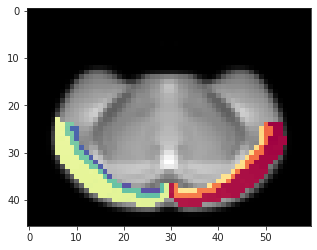

In [4]:
aa = in_house.numpy()[::-1][:, ::-1][..., 40].T
bb = ctx_inverted[..., 40].T

plt.imshow(aa, cmap='Greys_r')
plt.imshow(mwh(bb == 0, bb), cmap='Spectral');

In [5]:
regions = []
for lbl in mice.node_lookup['ca2'].values():
    r = mice.parcel.encode(lbl)
    if not (ctx == r).sum():
        continue
    regions.append(r)
regions = np.array(regions)
node_lookup = {
    n: r for n, r in
    enumerate(regions)
}
len(node_lookup)

531

In [6]:
roi = np.load(pjoin(tmp_dir, 'ROI_SanDiego.npy'))

In [7]:
regions = []
for lbl in mice.node_lookup['ca2'].values():
    r = mice.parcel.encode(lbl)
    if not (roi == r).sum():
        continue
    regions.append(r)
regions = np.array(regions)
node2region = {
    n: r for n, r in
    enumerate(regions)
}
len(node2region)

532

In [8]:
files = sorted(filter(
    lambda f: 'sub-DKI' in f or 'sub-WT'in f,
    os.listdir(mice.cfg.raw_dir),
))
len(files)

348

In [51]:
brain_mask = []
for f in files:
    x = ants.image_read(pjoin(mice.cfg.raw_dir, f))
    brain_mask.append(np.abs(x.numpy()).sum(-1) > 0)

In [52]:
len(brain_mask)

348

In [84]:
mask_all = functools.reduce(np.logical_or, brain_mask)

<matplotlib.image.AxesImage object at 0x7f8d2c095880>

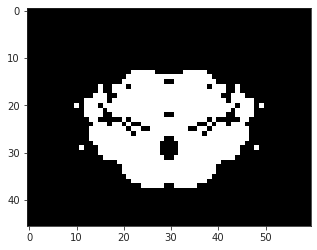

In [85]:
ii = 25
plt.imshow(mask_all[..., ii].T, cmap='Greys_r')

<matplotlib.image.AxesImage object at 0x7f8d2b21c640>

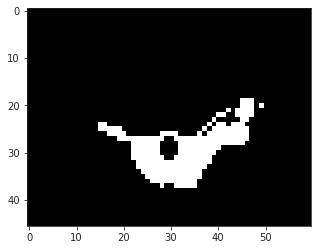

In [86]:
j = 18
ii = 25
plt.imshow(brain_mask[j][..., ii].T, cmap='Greys_r')

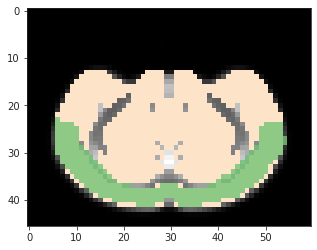

In [87]:
cc = mask_all[..., 40].T

plt.imshow(aa, cmap='Greys_r')
plt.imshow(mwh(cc == 0, cc), cmap='Oranges', vmin=0, vmax=7);
plt.imshow(mwh(bb == 0, bb > 0), cmap='Greens', alpha=0.8, vmin=0, vmax=2);

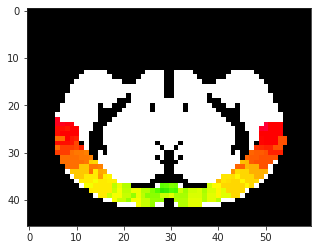

In [88]:
plt.imshow(mask_all[..., 40].T, cmap='Greys_r')
plt.imshow(mwh(ctx_inverted == 0, ctx_inverted)[..., 40].T, cmap='prism');

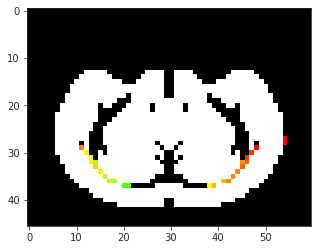

In [89]:
plt.imshow(mask_all[..., 40].T, cmap='Greys_r')
plt.imshow(mwh(~np.logical_and(~mask_all, ctx_inverted > 0), ctx_inverted)[..., 40].T, cmap='prism');

In [116]:
regions = []
for lbl in mice.node_lookup['ca2'].values():
    r = mice.parcel.encode(lbl)
    m = ctx_inverted == r
    if not (m.sum() and np.logical_and(m, mask_all).sum()):
        continue
    regions.append(r)
regions = np.array(regions)
node2region = {
    n: r for n, r in
    enumerate(regions)
}
len(node2region)

509

In [118]:
for f in files:
    x = ants.image_read(pjoin(mice.cfg.raw_dir, f)).numpy()
    data = np_nans((len(node2region), x.shape[-1]))
    for n, r in node2region.items():
        m = ctx_inverted == r
        data[n] = x[m].mean(0)
    break

In [120]:
data.shape

(509, 302)

In [128]:
mu, sd = data.mean(-1), data.std(-1)

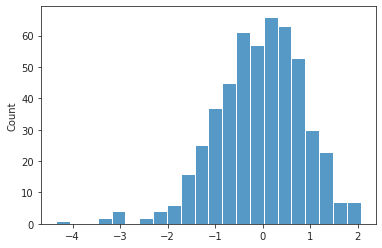

In [129]:
sns.histplot(mu);

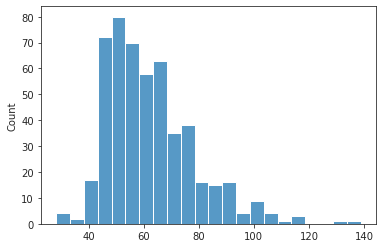

In [130]:
sns.histplot(sd);

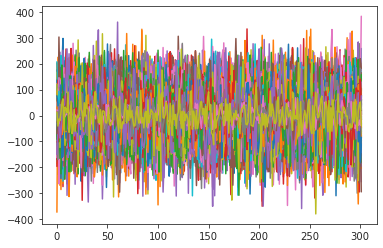

In [122]:
plt.plot(data.T);

<matplotlib.image.AxesImage object at 0x7f8d18472b50>

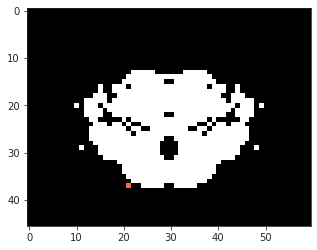

In [108]:
ii = 25
plt.imshow(mask_all[..., ii].T, cmap='Greys_r')
plt.imshow(mwh(m == 0, m)[..., ii].T, cmap='Reds', vmin=0, vmax=2)

[<matplotlib.lines.Line2D object at 0x7f8d17e64b50>]

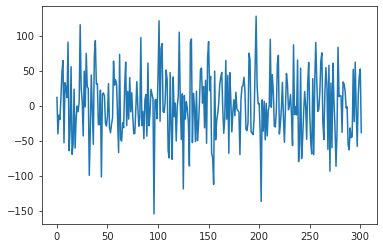

In [114]:
plt.plot()

## Now finalize

In [138]:
data_all = {}
for f in tqdm(files):
    x = ants.image_read(pjoin(mice.cfg.raw_dir, f)).numpy()
    data = np_nans((len(node2region), x.shape[-1]))
    for n, r in node2region.items():
        m = ctx_inverted == r
        data[n] = x[m].mean(0)
    key = '_'.join(f.split('_')[:3])
    data_all[key] = data

  0%|          | 0/348 [00:00<?, ?it/s]

In [139]:
list(data_all)

[
    'sub-DKI01_ses-1_run-1',
    'sub-DKI01_ses-1_run-2',
    'sub-DKI01_ses-1_run-3',
    'sub-DKI02_ses-1_run-1',
    'sub-DKI02_ses-1_run-2',
    'sub-DKI02_ses-1_run-3',
    'sub-DKI02_ses-2_run-1',
    'sub-DKI02_ses-2_run-2',
    'sub-DKI02_ses-2_run-3',
    'sub-DKI03_ses-1_run-1',
    'sub-DKI03_ses-1_run-2',
    'sub-DKI03_ses-1_run-3',
    'sub-DKI04_ses-1_run-1',
    'sub-DKI04_ses-1_run-2',
    'sub-DKI04_ses-1_run-3',
    'sub-DKI04_ses-2_run-1',
    'sub-DKI04_ses-2_run-2',
    'sub-DKI04_ses-2_run-3',
    'sub-DKI05_ses-1_run-1',
    'sub-DKI05_ses-1_run-2',
    'sub-DKI05_ses-1_run-3',
    'sub-DKI06_ses-1_run-1',
    'sub-DKI06_ses-1_run-2',
    'sub-DKI06_ses-1_run-3',
    'sub-DKI06_ses-2_run-1',
    'sub-DKI06_ses-2_run-2',
    'sub-DKI06_ses-2_run-3',
    'sub-DKI07_ses-1_run-1',
    'sub-DKI07_ses-1_run-2',
    'sub-DKI07_ses-1_run-3',
    'sub-DKI07_ses-2_run-1',
    'sub-DKI07_ses-2_run-2',
    'sub-DKI07_ses-2_run-3',
    'sub-DKI08_ses-1_run-1',
    'sub-DKI08_ses-1_run-2',
    'sub-DKI08_ses-1_run-3',
    'sub-DKI09_ses-1_run-1',
    'sub-DKI09_ses-1_run-2',
    'sub-DKI09_ses-1_run-3',
    'sub-DKI09_ses-2_run-1',
    'sub-DKI09_ses-2_run-2',
    'sub-DKI09_ses-2_run-3',
    'sub-DKI09_ses-3_run-1',
    'sub-DKI09_ses-3_run-2',
    'sub-DKI09_ses-3_run-3',
    'sub-DKI10_ses-1_run-1',
    'sub-DKI10_ses-1_run-2',
    'sub-DKI10_ses-1_run-3',
    'sub-DKI10_ses-2_run-1',
    'sub-DKI10_ses-2_run-2',
    'sub-DKI10_ses-2_run-3',
    'sub-DKI10_ses-3_run-1',
    'sub-DKI10_ses-3_run-2',
    'sub-DKI10_ses-3_run-3',
    'sub-DKI11_ses-1_run-1',
    'sub-DKI11_ses-1_run-2',
    'sub-DKI11_ses-1_run-3',
    'sub-DKI11_ses-2_run-1',
    'sub-DKI11_ses-2_run-2',
    'sub-DKI11_ses-2_run-3',
    'sub-DKI11_ses-3_run-1',
    'sub-DKI11_ses-3_run-2',
    'sub-DKI11_ses-3_run-3',
    'sub-DKI12_ses-1_run-1',
    'sub-DKI12_ses-1_run-2',
    'sub-DKI12_ses-1_run-3',
    'sub-DKI12_ses-2_run-1',
    'sub-DKI12_ses-2_run-2',
    'sub-DKI12_ses-2_run-3',
    'sub-DKI12_ses-3_run-1',
    'sub-DKI12_ses-3_run-2',
    'sub-DKI12_ses-3_run-3',
    'sub-DKI13_ses-1_run-1',
    'sub-DKI13_ses-1_run-2',
    'sub-DKI13_ses-1_run-3',
    'sub-DKI14_ses-1_run-1',
    'sub-DKI14_ses-1_run-2',
    'sub-DKI14_ses-1_run-3',
    'sub-DKI14_ses-3_run-1',
    'sub-DKI14_ses-3_run-2',
    'sub-DKI14_ses-3_run-3',
    'sub-DKI15_ses-1_run-1',
    'sub-DKI15_ses-1_run-2',
    'sub-DKI15_ses-1_run-3',
    'sub-DKI15_ses-3_run-1',
    'sub-DKI15_ses-3_run-2',
    'sub-DKI15_ses-3_run-3',
    'sub-DKI16_ses-3_run-1',
    'sub-DKI16_ses-3_run-2',
    'sub-DKI17_ses-3_run-1',
    'sub-DKI17_ses-3_run-2',
    'sub-DKI17_ses-3_run-3',
    'sub-DKI18_ses-3_run-1',
    'sub-DKI18_ses-3_run-2',
    'sub-DKI18_ses-3_run-3',
    'sub-DKI19_ses-3_run-1',
    'sub-DKI19_ses-3_run-2',
    'sub-DKI19_ses-3_run-3',
    'sub-DKI20_ses-3_run-1',
    'sub-DKI20_ses-3_run-2',
    'sub-DKI20_ses-3_run-3',
    'sub-DKI21_ses-2_run-1',
    'sub-DKI21_ses-2_run-2',
    'sub-DKI21_ses-2_run-3',
    'sub-DKI22_ses-5_run-1',
    'sub-DKI22_ses-5_run-2',
    'sub-DKI22_ses-5_run-3',
    'sub-DKI22_ses-6_run-1',
    'sub-DKI22_ses-6_run-2',
    'sub-DKI22_ses-6_run-3',
    'sub-DKI23_ses-5_run-1',
    'sub-DKI23_ses-5_run-2',
    'sub-DKI23_ses-5_run-3',
    'sub-DKI23_ses-6_run-1',
    'sub-DKI23_ses-6_run-2',
    'sub-DKI23_ses-6_run-3',
    'sub-DKI24_ses-5_run-1',
    'sub-DKI24_ses-5_run-2',
    'sub-DKI24_ses-5_run-3',
    'sub-DKI24_ses-6_run-1',
    'sub-DKI24_ses-6_run-2',
    'sub-DKI24_ses-6_run-3',
    'sub-DKI25_ses-5_run-1',
    'sub-DKI25_ses-5_run-2',
    'sub-DKI25_ses-5_run-3',
    'sub-DKI25_ses-6_run-1',
    'sub-DKI25_ses-6_run-2',
    'sub-DKI25_ses-6_run-3',
    'sub-DKI26_ses-5_run-1',
    'sub-DKI26_ses-5_run-2',
    'sub-DKI26_ses-6_run-1',
    'sub-DKI26_ses-6_run-2',
    'sub-DKI26_ses-6_run-3',
    'sub-DKI27_ses-5_run-1',
    'sub-DKI27_ses-5_run-2',
    'sub-DKI27_ses-5_run-3',
    'sub-DKI27_ses-6_run-1',
    'sub-DKI27_ses-6_run-

In [154]:
adj = {}
for key, data in tqdm(data_all.items()):
    a, p = get_adj_mat(data, 'pearson', p_val=1)
    adj[key] = a

  0%|          | 0/348 [00:00<?, ?it/s]

In [155]:
a_dki = [
    np.expand_dims(a, 0) for k, a
    in adj.items() if 'DKI' in k
]
a_wt = [
    np.expand_dims(a, 0) for k, a
    in adj.items() if 'WT' in k
]
a_dki = np.concatenate(a_dki)
a_wt = np.concatenate(a_wt)
a_dki.shape, a_wt.shape

((223, 509, 509), (125, 509, 509))

In [177]:
a_avg_dki = np.nanmean(a_dki, 0)
a_avg_wt = np.nanmean(a_wt, 0)

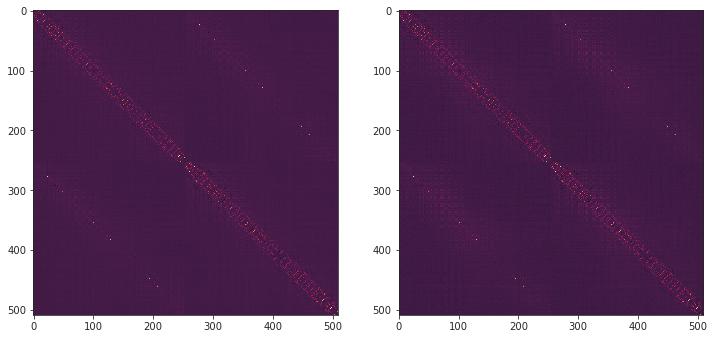

In [181]:
fig, axes = create_figure(1, 2, (12, 6))
axes[0].imshow(a_avg_dki)
axes[1].imshow(a_avg_wt)
plt.show()

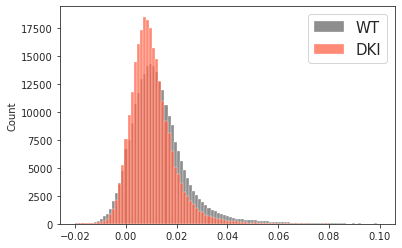

In [192]:
sns.histplot(a_avg_wt.ravel(), color='dimgrey', label='WT', bins=np.linspace(-0.02, 0.1, 100))
sns.histplot(a_avg_dki.ravel(), color='tomato', label='DKI', bins=np.linspace(-0.02, 0.1, 100))
plt.legend(fontsize=15)
plt.show()

In [200]:
bs = Base(mice, mode='ca2')
bs.n2l = {
    n: '-'.join(map(lambda x: str(x), mice.parcel.decode(r).ravel()))
    for n, r in node2region.items()
}

In [207]:
from sklearn.cluster import KMeans

num_k = 6
km_dki = KMeans(n_clusters=num_k, random_state=0).fit(a_avg_dki)
km_wt = KMeans(n_clusters=num_k, random_state=0).fit(a_avg_wt)
partition_dki = km_dki.labels_ + 1
partition_wt = km_wt.labels_ + 1

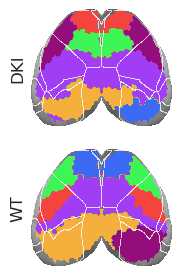

In [210]:
cmap = get_cluster_cmap(range(num_k))
_ = bs.show({
    'DKI': partition_dki,
    'WT': partition_wt},
    cmap=cmap,
    vmin=None,
    vmax=None,
    interpolation='none',
)

### Mega animal?

In [220]:
mega = {
    g: np.concatenate([
        x for _, x in filter(lambda tup: g in tup[0], data_all.items())
    ], -1) for g in ['DKI', 'WT']
}
{k: v.shape for k, v in mega.items()}

{'DKI': (509, 66239), 'WT': (509, 37141)}

In [221]:
a_mega_dki, _ = get_adj_mat(mega['DKI'], 'pearson', p_val=1)
a_mega_wt, _ = get_adj_mat(mega['WT'], 'pearson', p_val=1)

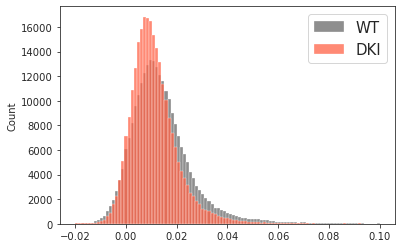

In [222]:
sns.histplot(a_mega_wt.ravel(), color='dimgrey', label='WT', bins=np.linspace(-0.02, 0.1, 100))
sns.histplot(a_mega_dki.ravel(), color='tomato', label='DKI', bins=np.linspace(-0.02, 0.1, 100))
plt.legend(fontsize=15)
plt.show()

In [223]:
num_k = 6
km_dki = KMeans(n_clusters=num_k, random_state=0).fit(a_mega_dki)
km_wt = KMeans(n_clusters=num_k, random_state=0).fit(a_mega_wt)
partition_dki = km_dki.labels_ + 1
partition_wt = km_wt.labels_ + 1

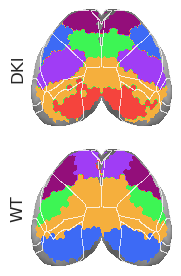

In [224]:
_ = bs.show({
    'DKI': partition_dki,
    'WT': partition_wt},
    cmap=get_cluster_cmap(range(num_k)),
    vmin=None,
    vmax=None,
    interpolation='none',
)